## Import Packages

In [37]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

import sklearn as sk
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
tf.__version__

'2.10.1'

## Reading the Data from system directory

In [3]:
working_dir = 'C:\\Users\\liyak\\OneDrive\\Documents\\Python Scripts\\Refactored_Py_DS_ML_Bootcamp-master\\22-Deep Learning pt - 2\\Data\\PetImages\\'

## Removing Corrupted Images

In [4]:
def CorruptImage():
    num_corrupted = 0
    for category in ("Cat", "Dog"):
        path = os.path.join(working_dir, category)
        
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                file_obj = open(img_path, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
            finally:
                file_obj.close()
            
            if not is_jfif:
                num_corrupted += 1
                os.remove(img_path)
    print("Total deleted images: ", num_corrupted)

In [5]:
CorruptImage()

Total deleted images:  0


## Removing Non JPG Images

In [6]:
def NonJpg():
    j = 0
    for category in os.listdir(working_dir):
        subFolder = os.path.join(working_dir, category)
        for name in os.listdir(subFolder):
            img_path = os.path.join(subFolder, name)
            if name.split('.')[1] == 'jpg':
                if os.path.getsize(img_path) <= 0:
                    if os.path.isfile(img_path) == False:
                        print(img_path)
                    os.remove(img_path)
                elif os.path.getsize(img_path) > 0:
                    j += 1
            if name.split('.')[1] != 'jpg':
                print(img_path)
                os.remove(img_path)
    print(j)

In [7]:
NonJpg()

23422


## Splitting of Dataset

In [8]:
image_size = (128, 128)

train_dataset = image_dataset_from_directory(
                working_dir,
                image_size=image_size,
                validation_split=.2,
                subset="training",
                batch_size=32,
                seed=1337,
                shuffle=True)

testing_dataset = image_dataset_from_directory(
                working_dir,
                image_size=image_size,
                validation_split=.2,
                subset="validation",
                batch_size=32,
                seed=1337,
                shuffle=True)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [9]:
print(len(train_dataset), len(testing_dataset))

586 147


## Data Visualization 

In [87]:
def data_visualization():
    plt.figure(figsize=(10,10))
    for images, labels in train_dataset.take(1):
        for i in range(16):
            ax =plt.subplot(4,4, i+1)
            plt.imshow((images[i].numpy().astype("uint8")))
            plt.title(int(labels[i]))
            plt.axis("off")

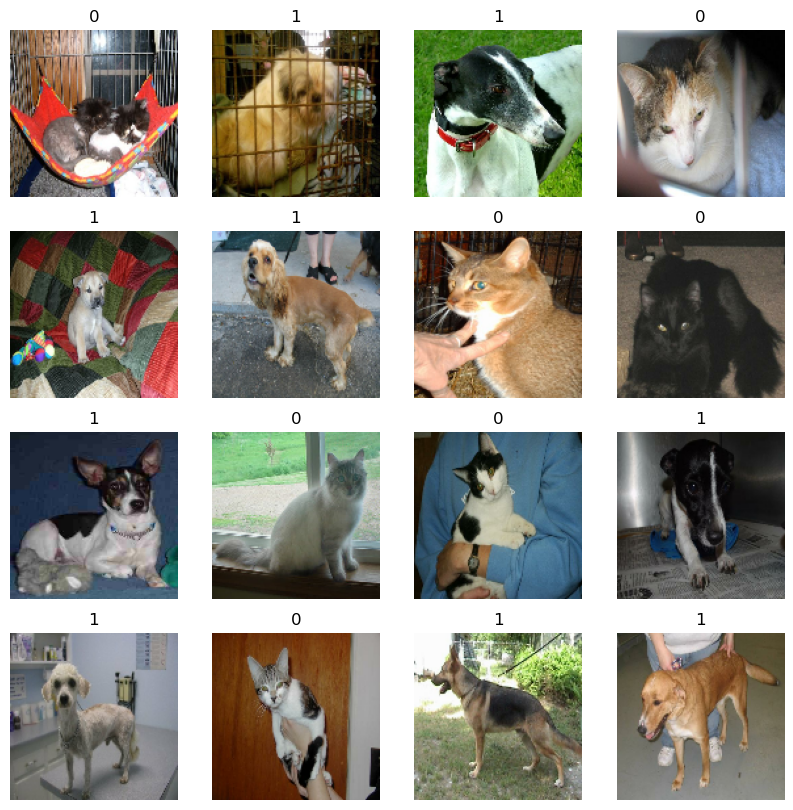

In [88]:
data_visualization()

## Classification Model using CNN and SVM using Dropout, Maxpool, Early Stopping 

In [12]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [20]:
model = Sequential()
model.add(Conv2D(filters=16, padding="same", kernel_size=3, activation='relu', strides=2, input_shape=[128, 128, 3]))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=2, pool_size=2))
model.add(Dropout(.3))

model.add(Conv2D(filters=32, padding="same", kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=2, pool_size=2))
model.add(Dropout(.3))

model.add(Conv2D(filters=64, padding="same", kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=2, pool_size=2))
model.add(Dropout(.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.01)))

# model.add(Dense(4, kernel_regularizer=l2(0.01), activation='softmax'))

model.compile(optimizer='adam', loss='squared_hinge', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)      

In [22]:
model.fit(train_dataset, validation_data=testing_dataset, epochs=15, callbacks=[early_stop])

Epoch 1/15
586/586 [==============================] - 12s 19ms/step - loss: 1.4484 - accuracy: 0.5553 - val_loss: 0.8966 - val_accuracy: 0.5111
Epoch 2/15
586/586 [==============================] - 11s 18ms/step - loss: 0.8865 - accuracy: 0.5992 - val_loss: 0.8968 - val_accuracy: 0.5474
Epoch 3/15
586/586 [==============================] - 11s 18ms/step - loss: 0.7528 - accuracy: 0.6432 - val_loss: 0.7219 - val_accuracy: 0.6445
Epoch 4/15
586/586 [==============================] - 11s 18ms/step - loss: 0.6914 - accuracy: 0.6724 - val_loss: 0.6693 - val_accuracy: 0.6424
Epoch 5/15
586/586 [==============================] - 11s 18ms/step - loss: 0.6459 - accuracy: 0.6983 - val_loss: 0.6073 - val_accuracy: 0.7359
Epoch 6/15
586/586 [==============================] - 11s 18ms/step - loss: 0.6186 - accuracy: 0.7125 - val_loss: 0.7802 - val_accuracy: 0.6465
Epoch 7/15
586/586 [==============================] - 11s 19ms/step - loss: 0.5808 - accuracy: 0.7323 - val_loss: 0.6583 - val_accuracy:

## Evaluation of the model

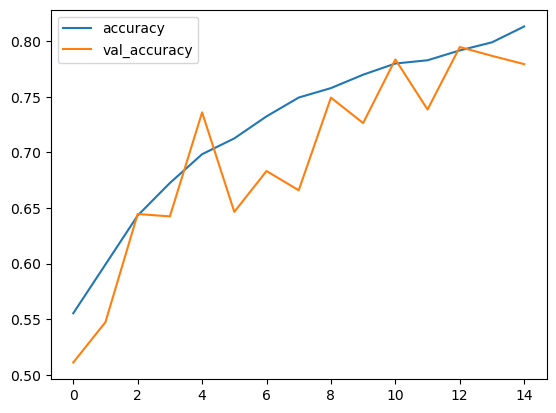

In [23]:
metrics = DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()

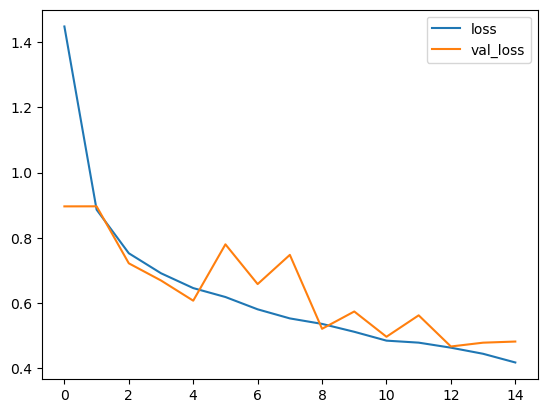

In [24]:
metrics[['loss', 'val_loss']].plot()

In [25]:
preds = model.predict(testing_dataset)

147/147 [==============================] - 2s 10ms/step


In [26]:
preds

array([[-0.8162526 ],
       [ 0.723992  ],
       [ 0.5649571 ],
       ...,
       [ 0.5008333 ],
       [-0.42406392],
       [-1.0265037 ]], dtype=float32)

## Taking a random Test Case 

In [55]:
image, label = list(train_dataset)[5]

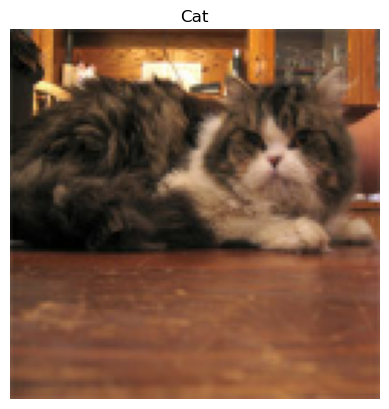

In [84]:
plt.imshow((image[5].numpy()).astype("uint8"))
plt.title("Cat" if label.numpy()[5] == 0 else "Dog")
plt.axis('OFF')
plt.show()

In [75]:
test = np.expand_dims(image[5].numpy() / 255, axis=0)

In [66]:
label.numpy()[5]

0

In [77]:
preds = model.predict(test)

1/1 [==============================] - 0s 16ms/step


In [78]:
if preds[0] < 0:
    print("This is a Cat image")
else:
    print("This is a Dog image")

This is a Cat image


## The Evaluation results of the model has an accuracy of about 80%. and the test case evaluated is classified as Cat which is True.